In [1]:
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm 
from sklearn.ensemble import IsolationForest
from scipy import stats
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

This codebook is the codebook used to review and analyze the cleaned data

# Load Dataset

In [2]:
df = pickle.load(open('final_df.pkl', 'rb'))

# Target Review

A brief look at the statistics shows a large range of gradaution rates from 1 to 99 and the data is centered around 68%. Looking at the historgram shows a significant spike around 50 with the majority of the data being 50% or higher and a small tail to the left. 

In [3]:
df['grad_rate'].describe()

count    144951.000000
mean         68.301329
std          17.546559
min           1.000000
25%          50.000000
50%          67.000000
75%          84.000000
max          99.000000
Name: grad_rate, dtype: float64

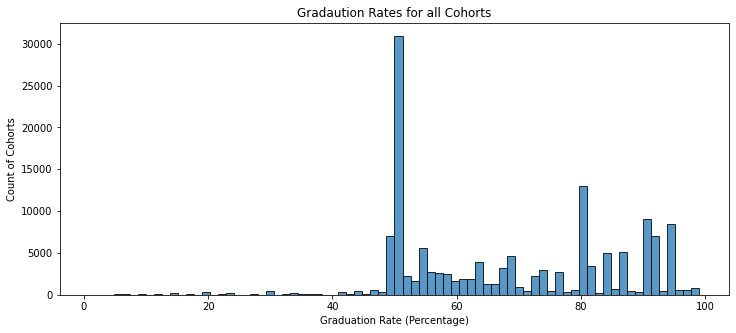

In [4]:
fig, ax = plt.subplots(figsize=(12,5))

sns.histplot(data=df, x='grad_rate', ax=ax)
plt.ylabel('Count of Cohorts')
plt.xlabel('Graduation Rate (Percentage)')
plt.title('Gradaution Rates for all Cohorts')

plt.show()

# Additional Feature Engineering

While the flags provided by the USDA do provide good detail on the different census tracts, the complexity of these flags and the amount of overlap make them difficult to assess and to use in an ANOVA test. Therefore, I will create a new feature 'tract_status'

1) Tract Status:
    0: Tract is not low food access under any measure
    1: Tract is low access under any of the measures, but is not low income
    2: Tract is low access under any of the measures, and is low income

In [5]:
# Function to classify tract status
def tract_status_update(row):
    LIStatus = (row['LILATracts_1And10'] + row['LILATracts_halfAnd10'] + row['LILATracts_1And20'] + row['LILATracts_Vehicle'])
    LAStatus = row['LA1and10'] + row['LAhalfand10'] + row['LA1and20'] + row['LATractsVehicle_20']
    # Checks if tract is marked as LILA under any measure
    if LIStatus > 0:
        return 2
    # Checks if tract is marked LA under any measure
    if LAStatus > 0:
        return 1
    else:
        return 0

df['tract_status'] = df.apply(tract_status_update, axis=1)

In [6]:
# Check structure of data
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144951 entries, 0 to 145323
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   ncessch               144951 non-null  category
 1   CensusTract           144951 non-null  category
 2   cohort_num            144951 non-null  int64   
 3   cohort_cat            144951 non-null  category
 4   school_level          144951 non-null  category
 5   charter               144951 non-null  category
 6   title_i_status        144951 non-null  category
 7   lunch_program         144951 non-null  category
 8   magnet                144951 non-null  category
 9   shared_time           144951 non-null  category
 10  virtual               144951 non-null  category
 11  LILATracts_1And10     144951 non-null  category
 12  LILATracts_halfAnd10  144951 non-null  category
 13  LILATracts_1And20     144951 non-null  category
 14  LILATracts_Vehicle    144951 non-nul

# Sample Selection

While I have already done some qualitative filtering of schools that I didn't feel were representative of the population I wanted to study. I'd like to do some additional review to determine if I should narrow the schools down that I include to try and control for other factors that may contribute to graduation rate differences

## Managing Unavailable Data

As a first step, I'll look at the magnet, shared time, and virtual schools to see if I can determine whether the schools that had that flag missing should be included in the population sample or not.

For the schools lacking this tag, I could not find a reliable, non-labor intensive way to validate whether they should be included in the analysis or not. Without further domain knowledge or extensisve research, my best option is to approximate the probability that these schools should be considered using a few different methods.

First, I am working under the assumption that there is a higher probability that any school missing this tag is *not* a school of that type, since schools of this type are less common. Therefore, without evidence to indicate that they should not be included, I will include them.

To look for this evidence I will look at two things. First I will use boxplots and the Kruskal-Willis test to assess whether it is likely that these schools come from the same population. 

Next, I will use countplots and a chi squared test to assess the likelihood that any difference in the medians is due to an unequal distribution across tract stuatuses rather than being from a different population.

The magnet school category does have some rows that are flagged with -2 instead of -1. This indicates that the flag is not applicable, rather than not reported. Since it is not applicable, I can assume that means that it is *not* a magnet school. So before completing the analysis I will update those schools accordingly.

Also, the virtual feature had cateogires of 0 for not virtual and 3 for 'supplemental virtual' which I included as essentially not-virtual. I will also update these to make the anlaysis easier.

In [7]:
# Update values
df['magnet'] = df['magnet'].apply(lambda x: 0 if x == -2 else x)
df['virtual'] = df['virtual'].apply(lambda x: 0 if x == 3 else x)

# Check that new values are just 0 and -1
print(df['magnet'].unique())
print(df['virtual'].unique())

[ 0. -1.]
[ 0. -1.]


In [8]:
# Calculate the Kruskal-Willis scores for the three features

magnet_kw = stats.kruskal(df[(df['magnet'] == -1)]['grad_rate'], df[(df['magnet'] == 0)]['grad_rate'])

shared_time_kw = stats.kruskal(df[df['shared_time'] == -1]['grad_rate'], df[df['shared_time'] == 0]['grad_rate'])

virtual_kw = stats.kruskal(df[df['virtual'] == -1]['grad_rate'], df[(df['virtual'] == 0)]['grad_rate'])

# Create the tables for the chi squared test
ctab_magnet = pd.crosstab(df['tract_status'], df['magnet'])

ctab_shared_time = pd.crosstab(df['tract_status'], df['shared_time'])

ctab_virtual = pd.crosstab(df['tract_status'], df['virtual'])

# Complete chi squared test for each feature
magnet_chi = stats.chi2_contingency(ctab_magnet)[1]

shared_time_chi = stats.chi2_contingency(ctab_shared_time)[1]

virtual_chi = stats.chi2_contingency(ctab_virtual)[1]

In all three cases, there is a statistically significant difference in the medians of the groups, but there is also evidence that the difference could be a result of their tract status since the chi squared test indicates a low probability that the schools are distributed among the different tract statuses equally. Teh box plots and the count plots also visually appear to align with this finding. 

Since I can't confidently disregard these schools, I will keep them in my dataset under the assumption that they are part of the population I want to study. 

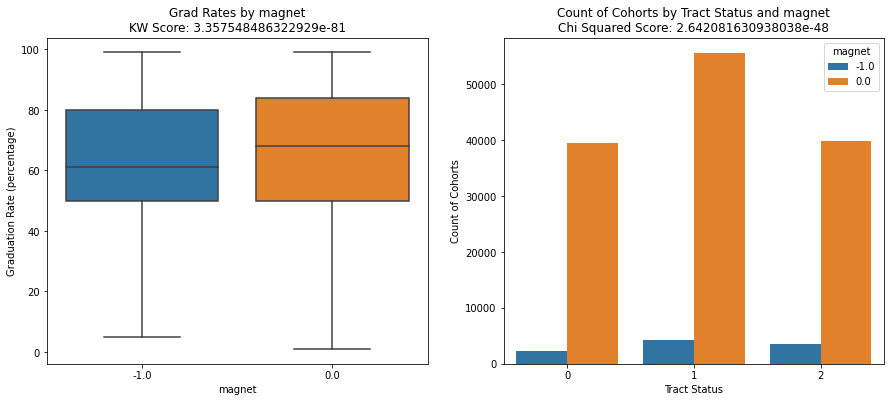

/mnt/c/Users/bcbot/dst1_env/lib/python3.10/site-packages/pandas/io/formats/format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())


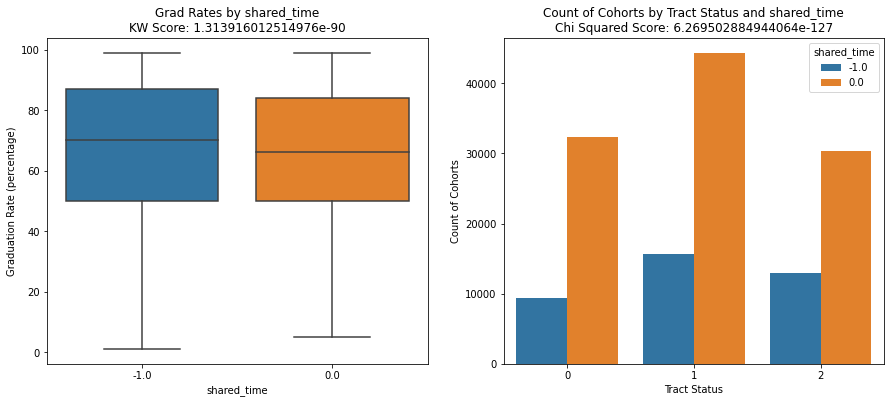

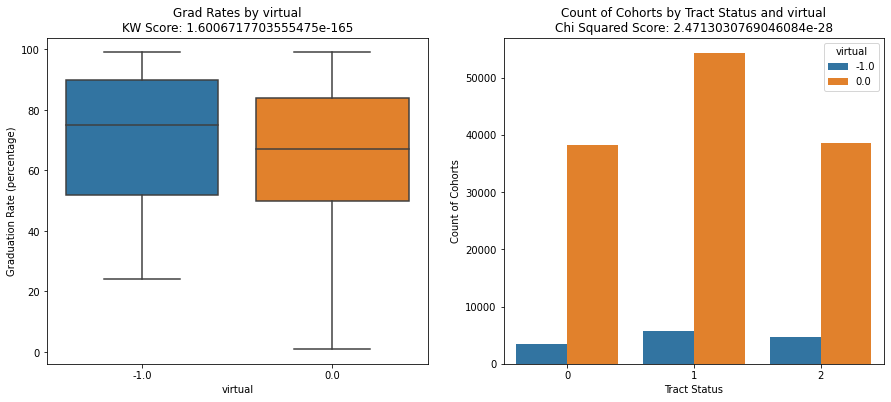

In [9]:

cols = ['magnet', 'shared_time', 'virtual']
score = [[magnet_kw, magnet_chi], [shared_time_kw, shared_time_chi], [virtual_kw, virtual_chi]]

# Loop for plotting the results
for i, col in enumerate(cols):
    # Get the kw and chi score for that feature from the list. 
    kw = score[i][0]
    chi = score[i][1]

    fig, ax = plt.subplots(ncols=2, figsize=(15,6))
    # Plot a box plot to visually assess data and kw score to statistically assess it
    sns.boxplot(data=df, y='grad_rate', x = col, ax=ax[0])
    ax[0].set_title(f'Grad Rates by {col}\nKW Score: {kw.pvalue}', loc='center')
    ax[0].set_ylabel('Graduation Rate (percentage)')
    # Plot countplot to visually assess distribution and chi square score to statistically assess it
    sns.countplot(data=df, x='tract_status', hue=col, ax=ax[1])
    ax[1].set_ylabel('Count of Cohorts')
    ax[1].set_xlabel('Tract Status')
    ax[1].set_title(f'Count of Cohorts by Tract Status and {col}\nChi Squared Score: {chi}', loc='center')
    
    plt.show()

In [10]:
# Dropping the columns
df.drop(columns=['magnet', 'shared_time', 'virtual'], inplace=True)

## Cohort Category

As would be expected from other research on education, graduation rates are highly varied for different cohorts with higher graduation rates for white students and lower graduation rates for other races. While it would be a very interesting study to look at whether certain cohorts experience a greater impact from food access than others, it would require a much more in depth review than the scope of this project. Additionally, knowing that the majority of my imputed values were for small sub-cohorts, removing them will somewhat mitigate any inaccuracy in the assumptions I made for that process. Therefore, I will drop the sub-cohorts from this dataset and focus only on the overall graduation rates for each school. 

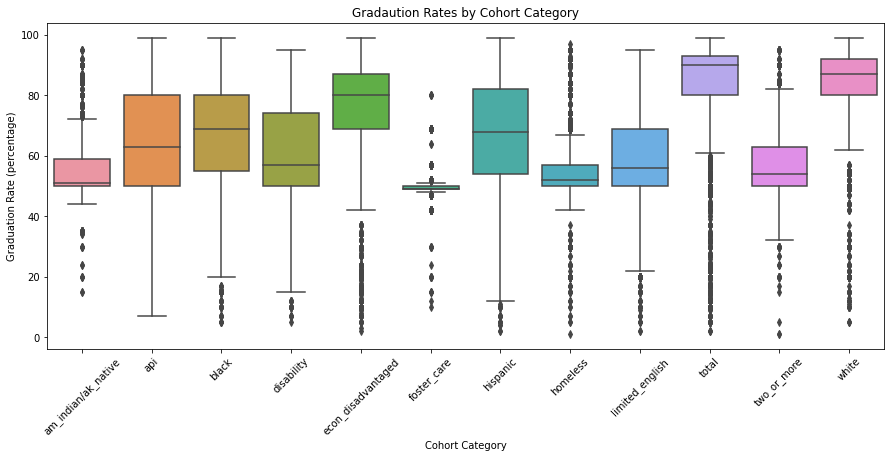

In [11]:
fig, ax = plt.subplots(figsize = (15, 6))

sns.boxplot(data = df, x= 'cohort_cat', y='grad_rate', ax=ax)
plt.xticks(rotation=45)
plt.ylabel('Graduation Rate (percentage)')
plt.xlabel('Cohort Category')
plt.title('Gradaution Rates by Cohort Category')

plt.show()

In [12]:
# Remove sub-cohorts from data

print(f'Prior to filtering there were {len(df)} observations')

df = df[df['cohort_cat'] == 'total']

print(df['cohort_cat'].unique())

# Drop column
df.drop(columns=['cohort_cat'], inplace=True)

print(f'After filtering there were {len(df)} observations')

Prior to filtering there were 144951 observations
['total']
Categories (12, object): ['am_indian/ak_native', 'api', 'black', 'disability', ..., 'limited_english', 'total', 'two_or_more', 'white']
After filtering there were 17037 observations


## School Level

School level indicates what grades are taught at that school (e.g. 6-8, 9-12, 6-12, etc.)

Once again, there is a fairly signficant variation in the different school levels. If graduation rates were less varied across the school level, I would consider using all of them in the analysis, but since there is significant variation I will pick a specific level to ensure that any differences identified in the test are focused on our feature of study. Since we know schools are going to be relatively equally distributed by level across geographies, there isn't a concern that school level and tract would be highly correlated. 

Primarily from my own interest, I will use category 3 which represents standard high school (grades 9-12). 

Note: There is one school that did not have the school level avaialble, however looking it up in nces.ed.gov it covers grades 7-12 so we will exclude it from our data.

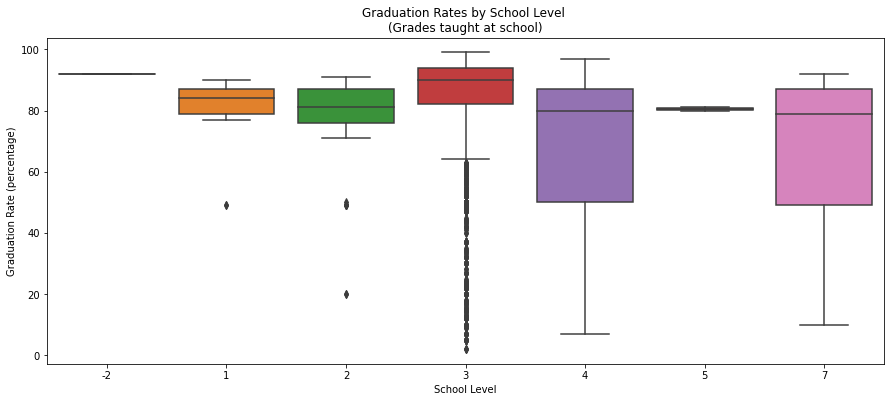

In [13]:
fig, ax = plt.subplots(figsize=(15,6))
sns.boxplot(data=df, x='school_level', y='grad_rate')
plt.ylabel('Graduation Rate (percentage)')
plt.xlabel('School Level')
plt.title('Graduation Rates by School Level \n(Grades taught at school)')

plt.show()

In [14]:
# Check school missing this information
df[df['school_level'] == -2]

,ncessch,CensusTract,cohort_num,school_level,charter,title_i_status,lunch_program,LILATracts_1And10,LILATracts_halfAnd10,LILATracts_1And20,LILATracts_Vehicle,LA1and10,LAhalfand10,LA1and20,LATractsVehicle_20,grad_rate,tract_status
23336,60254208363,6087101200,88,-2,1,6.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,92,2


In [15]:
# Remove all schools except level 3
print(f'Prior to filtering there were {len(df)} observations')
df = df[df['school_level'] == 3]

print(df['school_level'].unique())

# Drop column
df.drop(columns=['school_level'], inplace=True)

print(f'After filtering there were {len(df)} observations')

Prior to filtering there were 17037 observations
[3]
Categories (7, int64): [-2, 1, 2, 3, 4, 5, 7]
After filtering there were 15365 observations


# Target Review

Now that I've limited the population of interest to just overall graduation rates for high school, I will look at the distribution again to see how it's changed.

It looks like these adjustments have significantly changed the distribution. The spike at 50% had decreased significantly, this makes sense since from the cohort boxplot we could see that much of that seemed to be a result of certain cohorts having lower rates and cluserting around that rate. 

We now have a highly skewed plot with the majority of graduation rates at or above 80 and a long tail for gradution rates down to 2.

In [16]:
df['grad_rate'].describe()

count    15365.000000
mean        85.017898
std         14.383703
min          2.000000
25%         82.000000
50%         90.000000
75%         94.000000
max         99.000000
Name: grad_rate, dtype: float64

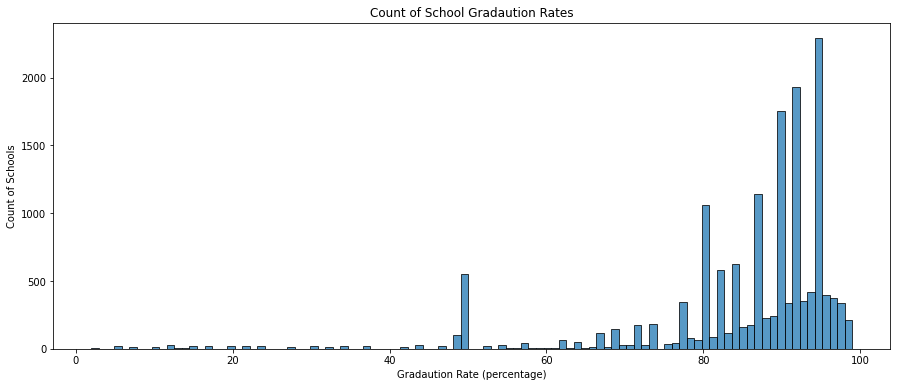

In [17]:
fig, ax = plt.subplots(figsize=(15,6))

sns.histplot(data=df, x='grad_rate', ax=ax)
plt.xlabel('Gradaution Rate (percentage)')
plt.ylabel('Count of Schools')
plt.title('Count of School Gradaution Rates')

plt.show()

# Analyzing Other Features

For the remaining features, I will explore if any of them appear to have large differences in graduation rates. If they do, I will add them as an interaction to my analysis to see if there's a relationship between that feature and tract_status

Before plotting these datapoints there are a few things I can do to make it a little easier to review:

1) Charter has a number of schools marked as -2 indicating that the charter tag is not applicable, since this indicates they are not charters, I will update those to category 0.
2) title_i_status is broken down into 6 categories depending on which program the school is eligible for and if they are participating. To simplify this I will create a new feature with just 3 categories: 0 - not eligible, 1 - eligible and offers program, 2 - elgibile and does not offer program. 
3) lunch_program provides 5 categories that specify whether a school is participating and if so, what provision it is participating under. I am going to simplify this data by just looking at whether a school is participating (1) or not (0).

In [18]:
# Update Charter School values

# Update values
df['charter'] = df['charter'].apply(lambda x: 0 if x== -2 else x)

#Check new values
df['charter'].unique()

# Update tract_i_status

def title_i_update (x):
    if x in [1, 4]:
        return 2
    if x in [2, 3, 5]:
        return 1
    if x == 6:
        return 0
    else: 
        return -1

df['title_i'] = df['title_i_status'].apply(title_i_update)

df.drop(columns=['title_i_status'], inplace=True)

# Update lunch_program

def lunch_update (x):
    if x == 0:
        return 0
    if x in [1, 2, 3, 4, 5]:
        return 1
    else:
        return -1

df['nslp'] = df['lunch_program'].apply(lunch_update)

df.drop(columns=['lunch_program'], inplace=True)

Looking at the plots of each of the additional features, it appears that participation in the school lunch program doesn't have much of an impact on graduation rates. 

Title I participation appears to have more of an impact, but because one of primary features of the model is looking at income status, and title I uses low income status to determine eligibility, this runs a high risk of colinearity. This concern is supported by viewing the highly unequal distribution across the different tracts. 

Finally charter does seem to have a significant impact, and doesn't seem to be as correlated as title I. However, the sample sizes are highly unequal. I will include this in the model, but any conclusions about charter schools should be limited because of the unequal sizes. 

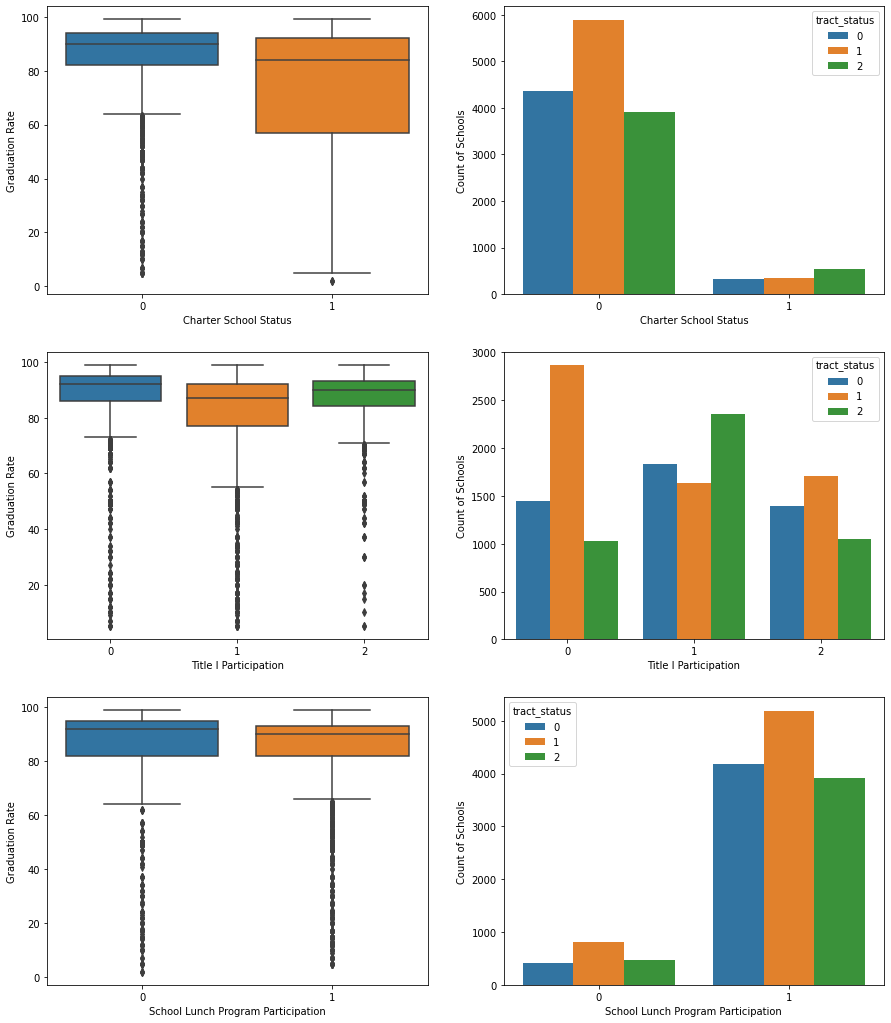

In [19]:
alt_feats = ['charter', 'title_i', 'nslp']
title = ['Charter School Status', 'Title I Participation', 'School Lunch Program Participation']

fig, ax = plt.subplots(ncols=2, nrows=3, figsize = (15,6*len(alt_feats)))

idx = 0
for feat in alt_feats:
    sns.boxplot(data=df[df[feat] != -1], y='grad_rate', x=feat, ax=ax[idx][0])
    sns.countplot(data=df[df[feat] != -1], x=feat, hue='tract_status', ax=ax[idx][1])

    ax[idx][0].set_ylabel('Graduation Rate')
    ax[idx][1].set_ylabel('Count of Schools')
    ax[idx][0].set_xlabel(title[idx])
    ax[idx][1].set_xlabel(title[idx])

    idx += 1

plt.show()

In [20]:
# Drop unecessary columns

df.drop(columns=['nslp', 'title_i'], inplace=True)

# Target Data Exploration

Now that I have filtered and adjusted the data to create reasonably similar groups and identified the features I'll be assessing, I can look at the relationship between food access and graduation rates using the provided feaures and the ones I created

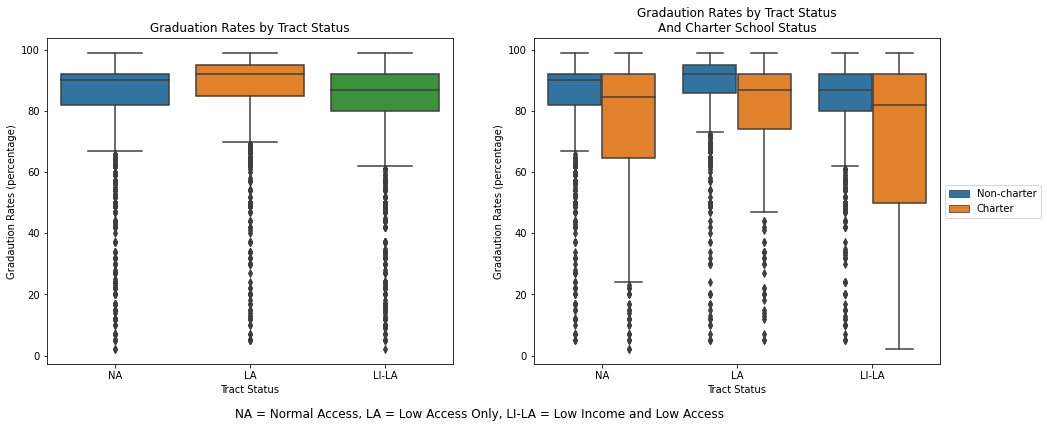

In [21]:
# Plot gradaution rates by the tract status feature
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (16, 6))

sns.boxplot(data=df, x='tract_status', y='grad_rate', ax = ax1)
sns.boxplot(data=df, x='tract_status', y='grad_rate', hue='charter', ax = ax2)

ax1.set_ylabel('Gradaution Rates (percentage)')
ax1.set_xlabel('Tract Status')
ax1.set_title('Graduation Rates by Tract Status')

ax2.set_ylabel('Gradaution Rates (percentage)')
ax2.set_xlabel('Tract Status')
ax2.set_title('Gradaution Rates by Tract Status\nAnd Charter School Status')

xlabels = ['NA', 'LA', 'LI-LA']

for ax in [ax1, ax2]:
    ax.set_xticklabels(xlabels)

handles, labels = ax2.get_legend_handles_labels()
new_labels = ['Non-charter', 'Charter']
ax2.legend(handles, new_labels, loc='center left', bbox_to_anchor=(1.0, 0.5))

fig.text(0.5, 0.001, 'NA = Normal Access, LA = Low Access Only, LI-LA = Low Income and Low Access', ha='center', fontsize=12)

plt.show()

# Outlier Detection

To explore outliers, I chose to use an Isolation Forest method to isolate any data points that, when looking at the entire set of features, appear to be outliers. Without having a good way to estimate contamination, I explored several contamination options

Looking at the different contamination rates, the jump from 0 to 330 outliers indicates that those are not outliers, just a different grouping. Without any additional domain knowledge to inform this decision, I will choose to leave all the data points in.

/mnt/c/Users/bcbot/dst1_env/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


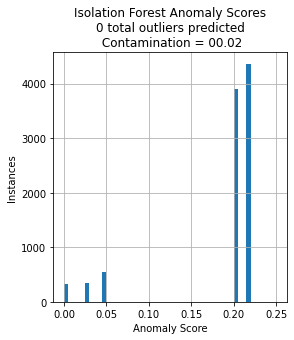

/mnt/c/Users/bcbot/dst1_env/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


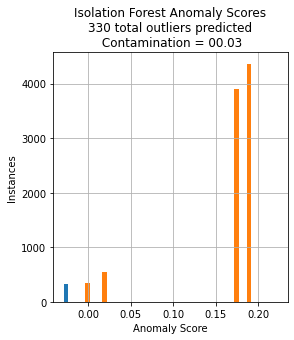

/mnt/c/Users/bcbot/dst1_env/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


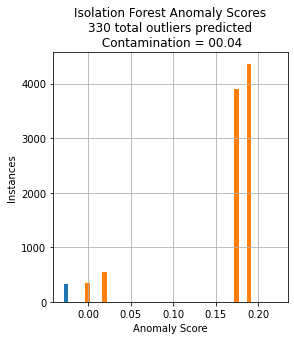

In [22]:
features = df[['charter', 'tract_status']]
contam = [0.02, 0.03, 0.04]
for c in contam:
      clf = IsolationForest(random_state=7284, contamination= c)
                        

      clf.fit(features)


      iso_forest_predictions = pd.DataFrame(np.c_[clf.predict(features), 
                                                clf.decision_function(features)], 
                                          columns= ['anomaly_flag', 'anomaly_score'])

      num_outliers = len(iso_forest_predictions[iso_forest_predictions['anomaly_flag'] == -1])
      fig, ax = plt.subplots()
      iso_forest_predictions.groupby(['anomaly_flag'])['anomaly_score'].hist(
      bins= np.arange(np.min(clf.decision_function(features)), 
                        np.max(clf.decision_function(features)), 0.005),  
      figsize= (4, 4), ax= ax)
      fig.tight_layout()
      plt.xlabel('Anomaly Score')
      plt.ylabel('Instances')
      plt.title(f'Isolation Forest Anomaly Scores\n{num_outliers} total outliers predicted\n Contamination = 0{c}')
      plt.show()

# Transformation of Data

I know that the data is highly skewed and I can see from the boxplots that the variance is varied for many of the categories. Since these are both key assumptions for ANOVA I needed to transform my data into a more normal distribution. To do this, I chose to use the boxcox transformation which can help normalize both the distribution and the varaince. As a plus, it will also help mitigate the influence of outliers if my previous assumption was incorrect. 

In [23]:
data_fit, lambda_fit = stats.boxcox(df['grad_rate'])

df['grad_rate_box'] = data_fit

Looking at the new histogram, as well as relooking at a couple boxplots of the features, I can see that the varaince and the distribution are now much better and I can now use the data to perform the ANOVA test

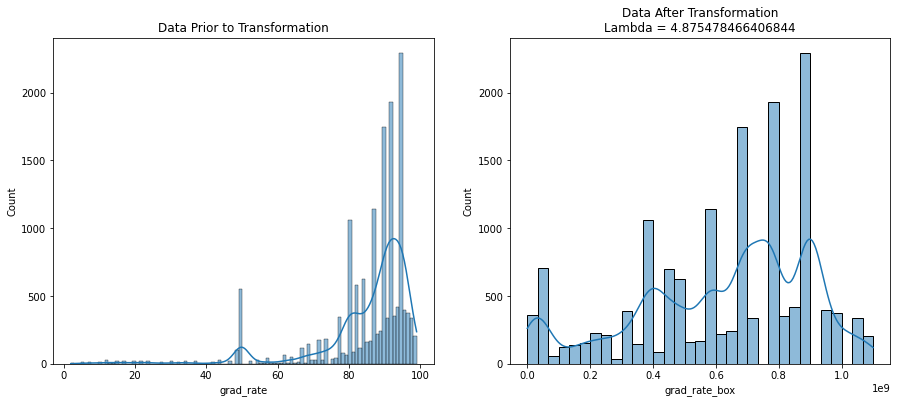

In [24]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 6))
 

sns.histplot(df['grad_rate'], kde = True, ax=ax[0])
sns.histplot(df['grad_rate_box'], kde=True, ax=ax[1])
 
ax[0].set_title('Data Prior to Transformation')
ax[1].set_title(f'Data After Transformation\nLambda = {lambda_fit}')


plt.show()

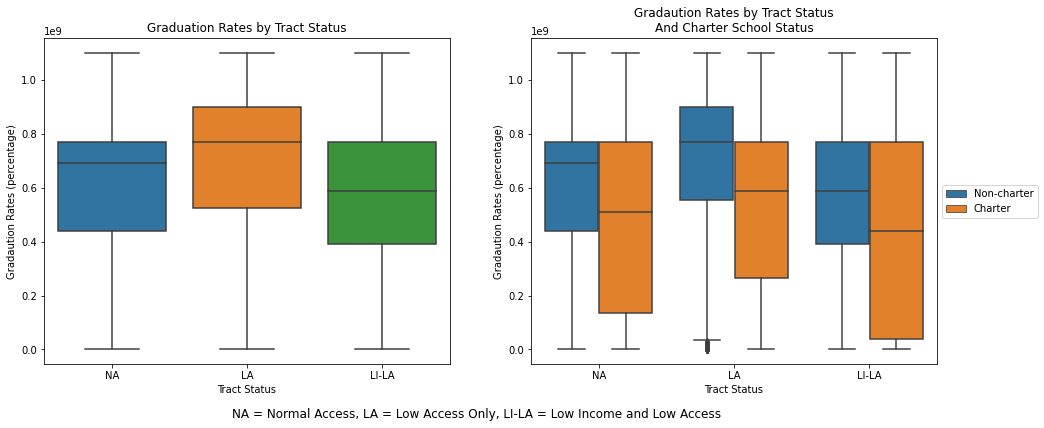

In [25]:
# Plot gradaution rates by the tract status feature
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (16, 6))

sns.boxplot(data=df, x='tract_status', y='grad_rate_box', ax = ax1)
sns.boxplot(data=df, x='tract_status', y='grad_rate_box', hue='charter', ax = ax2)

ax1.set_ylabel('Gradaution Rates (percentage)')
ax1.set_xlabel('Tract Status')
ax1.set_title('Graduation Rates by Tract Status')

ax2.set_ylabel('Gradaution Rates (percentage)')
ax2.set_xlabel('Tract Status')
ax2.set_title('Gradaution Rates by Tract Status\nAnd Charter School Status')

xlabels = ['NA', 'LA', 'LI-LA']

for ax in [ax1, ax2]:
    ax.set_xticklabels(xlabels)

handles, labels = ax2.get_legend_handles_labels()
new_labels = ['Non-charter', 'Charter']
ax2.legend(handles, new_labels, loc='center left', bbox_to_anchor=(1.0, 0.5))

fig.text(0.5, 0.001, 'NA = Normal Access, LA = Low Access Only, LI-LA = Low Income and Low Access', ha='center', fontsize=12)

plt.show()

# Statistical Analysis

For my final analysis, I performed a two-way ANOVA test with the boxcox transformed graduation rates grouped by tract status and charter school status with interaction between tract status and charter school status

In [26]:
df_core = df[['grad_rate_box', 'tract_status', 'charter']]

df[['tract_status', 'charter']] = df[['tract_status', 'charter']].astype('category')

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15365 entries, 0 to 145320
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   ncessch               15365 non-null  category
 1   CensusTract           15365 non-null  category
 2   cohort_num            15365 non-null  int64   
 3   charter               15365 non-null  category
 4   LILATracts_1And10     15365 non-null  category
 5   LILATracts_halfAnd10  15365 non-null  category
 6   LILATracts_1And20     15365 non-null  category
 7   LILATracts_Vehicle    15365 non-null  category
 8   LA1and10              15365 non-null  category
 9   LAhalfand10           15365 non-null  category
 10  LA1and20              15365 non-null  category
 11  LATractsVehicle_20    15365 non-null  category
 12  grad_rate             15365 non-null  int64   
 13  tract_status          15365 non-null  category
 14  grad_rate_box         15365 non-null  float64 
dtypes

One other assumption of ANOVA is equal populations among the sample sizes. Looking at a crosstable of the results, there does appear to be a relatively equal distribution across the tract status category, but the distribution across charter status is highly unbalanced. 

This does not mean I can't use it, just that the results regarding charter should be taken with some caution since the test may be overly sensitive to assuming differences. 

In [27]:
c_tab = pd.crosstab(df['tract_status'], df['charter'])

print(c_tab)

charter          0    1
tract_status           
0             4356  330
1             5886  343
2             3902  548


The results of the ANOVA show a p-value of less than .0001 for both tract status and charter school status, indicating that there is a statistically significant difference between the means of schools among those groups. However, the interaction of tract status and charter school has a p-value of 0.169 indicating that there is not an interaction between tract status and charter status in determining graduation rates. 

In [28]:
model = ols('grad_rate_box ~ C(tract_status) + C(charter) + C(tract_status):C(charter)', data=df_core).fit()

sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(tract_status),3.638567e+19,2.0,254.396323,2.030538e-109
C(charter),2.391848e+19,1.0,334.459844,6.245836e-74
C(tract_status):C(charter),2.542102e+17,2.0,1.777352,1.691201e-01
Residual,1.098380e+21,15359.0,NaN,NaN


Because there is evidence that there is a difference in graduation rates among the different tract statuses, I will perform tukey's pariwise test to assess if that is a result of a specific group or more than one.

In all three cases tukey's test finds a p-value of less than 0.05, meaning all three groups have a statitistically significant difference in means. 

In [29]:
tukey = pairwise_tukeyhsd(endog=df_core['grad_rate_box'], groups=df['tract_status'], alpha=0.05)

tukey.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
0,1,70832196.4773,-0.0,58579679.8259,83084713.1287,True
0,2,-56015757.6282,-0.0,-69278112.2639,-42753402.9926,True
1,2,-126847954.1055,-0.0,-139284502.4168,-114411405.7943,True


# Conclusion

The final analysis indicates that both food access and a combination of food access and low income status impact high school graduation rates. It also indicates that, while charter schools may impact graduation rates, it does not appear that they interact with food access status.

As noted previously, there are some challenges with the data avaialble such as the ranges of graduation rates, that make it difficult to draw any concrete findings from this project. However, given the results of the ANOVA it does indicate that this would be a worthwhile study to explore in more depth with more accurate data.